In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import wandb
from config import BATCH_SIZE

import dataloaders
import utils
from importlib import reload
import config
reload(config)
reload(utils)
reload(dataloaders)

<module 'dataloaders' from '/Users/dov/Library/Mobile Documents/com~apple~CloudDocs/dovsync/Documenti Universita/Advanced Machine Learning/AML Project.nosync/melanoma-detection/dataloaders.py'>

In [2]:
# Configurations
INPUT_SIZE = 3
NUM_CLASSES = 7
HIDDEN_SIZE = [32, 64, 128, 256]
N_EPOCHS = 10
LR = 1e-3
LR_DECAY = 0.85
REG = 0.01
SEGMENT = True
CROP_ROI = True
ARCHITECHTURE = "resnet24"
DATASET_LIMIT = None

if CROP_ROI:
    assert SEGMENT, f"Crop roi needs segment to be True"

In [4]:
# Weight initilization
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [5]:
RANDOM_SEED = 42 

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(RANDOM_SEED)

Random seed set as 42


In [6]:
# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps")
print('Using device: %s'%device)

Using device: mps


In [7]:
# Load the dataset
train_loader, val_loader, test_loader = dataloaders.create_dataloaders(
    limit=DATASET_LIMIT)

------Check distribution-----
Labels percentages for train are [('akiec', 0.03), ('bcc', 0.05), ('bkl', 0.11), ('df', 0.01), ('mel', 0.11), ('nv', 0.67), ('vasc', 0.01)]
Labels percentages for val are [('akiec', 0.03), ('bcc', 0.05), ('bkl', 0.11), ('df', 0.01), ('mel', 0.11), ('nv', 0.67), ('vasc', 0.01)]
Labels percentages for test are [('akiec', 0.03), ('bcc', 0.06), ('bkl', 0.14), ('df', 0.03), ('mel', 0.11), ('nv', 0.6), ('vasc', 0.02)]
-----------------------------
Max count is 5364, while second max count is 890
Max labels to remove is 2682


Loading train images: 5781it [00:52, 134.56it/s]

In [ ]:
# # Note: Code to visualize data. To remove or modify. Stop this cell manually!
# for (batch, labels, segmentations) in train_loader:
#         masked_image = torch.mul(batch, segmentations)
#         masked_image = masked_image.to(device)

#         num_images = masked_image.shape[0]
#         rows = 4
#         cols = 8

#         fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

#         for i in range(rows):
#             for j in range(cols):
#                 if i * cols + j < num_images:
#                     axes[i, j].imshow(np.transpose(masked_image[i * cols + j], (1, 2, 0)))
#                     axes[i, j].axis('off')

#         plt.show()

In [ ]:
class ResNet24Pretrained(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None):
        super(ResNet24Pretrained, self).__init__()
        self.model = models.resnet34(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(self.model.fc.in_features, 256, bias=False),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, 128, bias=False),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, num_classes, bias=False),
            nn.BatchNorm1d(num_classes),
        )
        self.model.fc = self.classifier

        model_parameters = filter(lambda p: p.requires_grad, self.model.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print(f'Model has {params} trainable params.')
    
    def forward(self, x):
        return self.model(x)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [ ]:
class DenseNetPretrained(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None):
        super(DenseNetPretrained, self).__init__()
        self.model = models.densenet121(pretrained=True)
            
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.1),
        
            nn.Linear(self.model.classifier.in_features, 256, bias=False), 
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, 128, bias=False),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, num_classes, bias=False),
            nn.BatchNorm1d(num_classes), 
        )
            
        self.model.classifier = self.classifier

        model_parameters = filter(lambda p: p.requires_grad, self.model.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print(f'Model has {params} trainable params.')
    
    def forward(self, x):
        return self.model(x)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [ ]:
# Start a new run 
wandb.init(
    project="melanoma",

    # track hyperparameters and run metadata
    config={
        "learning_rate": LR,
        "architecture": ARCHITECHTURE,
        "epochs": N_EPOCHS,
        'reg': REG,
        'batch_size': BATCH_SIZE,
        "hidden_size": HIDDEN_SIZE,
        "dataset": "HAM10K",
        "optimizer": "AdamW",
        "segmentation": SEGMENT,
        "crop_roi": CROP_ROI,
        "dataset_limit": DATASET_LIMIT,
    }
)

In [ ]:
if ARCHITECHTURE == "resnet24":
    model = ResNet24Pretrained(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES, norm_layer='BN').to(device)
elif ARCHITECHTURE == "densenet121":
    model = DenseNetPretrained(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES, norm_layer='BN').to(device)
else:
    raise ValueError(f"Unknown architechture {ARCHITECHTURE}")

# Freezing pretrained CNN backbone for classifier head fine tuning

for p in model.parameters():
    p.requires_grad=False

# LAYERS_TO_FINE_TUNE = 20
# parameters = list(model.parameters())
# for p in parameters[-LAYERS_TO_FINE_TUNE:]:
#     p.requires_grad=True
    
for p in model.classifier.parameters():
    p.requires_grad=True


for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

/Users/dov/miniconda3/envs/aml_project/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dov/miniconda3/envs/aml_project/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model has 21450190 trainable params.
model.fc.1.weight
model.fc.3.weight
model.fc.3.bias
model.fc.4.weight
model.fc.6.weight
model.fc.6.bias
model.fc.7.weight
model.fc.8.weight
model.fc.8.bias


In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=REG)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

In [ ]:
# for batch_idx, (images, labels, _) in enumerate(train_loader):
#     # Print the size of each image in the batch
#     print(f"Batch {batch_idx + 1}, Image size: {images.size()}")

In [ ]:
from tqdm.notebook import tqdm
total_step = len(train_loader)
train_losses = []
val_losses = []
best_accuracy = None
val_accuracies = []
best_model = type(model)(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES, norm_layer='BN') # get a new instance
for epoch in range(N_EPOCHS):
    model.train()
    tr_loss_iter = 0
    training_count = 0
    training_correct_preds = 0
    for tr_i, (tr_images, tr_labels, segmentations) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        if SEGMENT:
            tr_images = torch.mul(tr_images, segmentations) #Apply segmentation
            if CROP_ROI:
                tr_images = utils.crop_roi(tr_images)
        tr_images = tr_images.to(device)
        tr_labels = tr_labels.to(device)

        tr_outputs = model(tr_images) #Prediction
        tr_loss = loss_function(tr_outputs, tr_labels)
        wandb.log({"Training Loss": tr_loss.item()})

        optimizer.zero_grad()
        tr_loss.backward()
        optimizer.step()

        with torch.no_grad():
            training_preds = torch.argmax(tr_outputs, -1).detach()
            training_count += len(tr_labels)
            training_correct_preds += (training_preds == tr_labels).sum()

        tr_loss_iter += tr_loss.item()

    
    current_train_accuracy = 100 * (training_correct_preds/training_count)
    wandb.log({"Training Accuracy": current_train_accuracy})
    print ('Training -> Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}%'
            .format(epoch+1, N_EPOCHS, tr_i+1, total_step, tr_loss.item(), current_train_accuracy))
            
    train_losses.append(tr_loss_iter/(len(train_loader)*BATCH_SIZE))

    #LR *= LR_DECAY
    #update_lr(optimizer, LR)

    model.eval()
    with torch.no_grad():
        validation_correct_preds = 0
        validation_count = 0
        val_loss_iter = 0
        for val_i, (val_images, val_labels, segmentations) in enumerate(val_loader):
            if SEGMENT:
                val_images = torch.mul(val_images, segmentations) #Apply segmentation
                if CROP_ROI:
                    val_images = utils.crop_roi(val_images)
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = model(val_images)
            validation_preds = torch.argmax(val_outputs, -1).detach()   
            validation_count += len(val_labels)
            validation_correct_preds += (validation_preds == val_labels).sum()
            
            val_loss = loss_function(val_outputs, val_labels)
            wandb.log({"Validation Loss": val_loss.item()})
            val_loss_iter += val_loss.item()
        
        val_losses.append(val_loss_iter/(len(val_loader)*BATCH_SIZE))

        val_accuracy = 100 * (validation_correct_preds / validation_count)
        val_accuracies.append(val_accuracy)
        wandb.log({"Validation Accuracy": val_accuracy})
        print('Validation -> Validation accuracy for epoch {} is: {:.4f}%'.format(epoch+1, val_accuracy))
        print('Validation -> Validation loss for epoch {} is: {:.4f}'.format(epoch+1, val_loss.item()))

Model has 21450190 trainable params.


Training:   0%|          | 0/294 [00:00<?, ?it/s]

Training -> Epoch [1/10], Step [294/294], Loss: 0.8630, Accuracy: 65.2498%
Validation -> Validation accuracy for epoch 1 is: 57.7134%
Validation -> Validation loss for epoch 1 is: 1.5916


Training:   0%|          | 0/294 [00:00<?, ?it/s]

KeyboardInterrupt: 

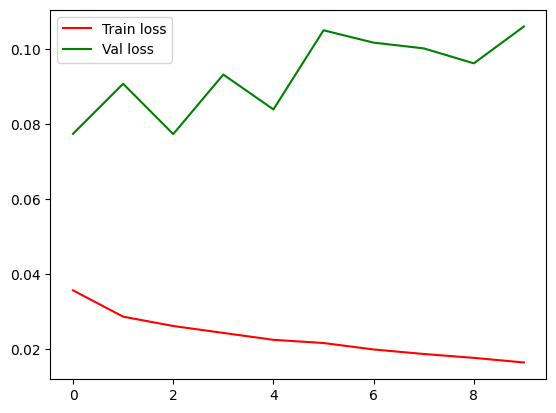

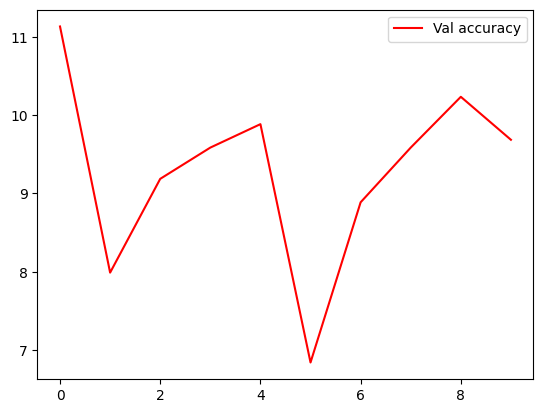

In [ ]:
model.eval()

plt.figure(2)
plt.plot(train_losses, 'r', label='Train loss')
plt.plot(val_losses, 'g', label='Val loss')
plt.legend()
plt.show()

plt.figure(3)
plt.plot([val_accuracy.cpu() for val_accuracy in val_accuracies], 'r', label='Val accuracy')
plt.legend()
plt.show()